# Introduction to the Dataset 

Many U.S. cities have communal bike sharing stations where we can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

[Hadi Fanaee-T][1] at the [University of Porto][2] compiled this data into a CSV file, which we'll work with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. The data can be downloaded from the [University of California, Irvine's website.][3]

[1]: http://www.fanaee.com/
[2]: https://sigarra.up.pt/up/pt/web_base.gera_pagina?p_pagina=home
[3]: http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#

## About the data

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

Here are the descriptions for the relevant columns:
- `instant` - A unique sequential ID number for each row (record index)
- `dteday` - The date of the rentals
- `season` - The season in which the rentals occurred
   * 1: winter
   * 2: spring
   * 3: summer
   * 4: fall
- `yr` - The year the rentals occurred
   * 0: 2011
   * 1: 2012
- `mnth` - The month the rentals occurred (1 to 12)
- `hr` - The hour the rentals occurred (0 to 23)
- `holiday` - Whether or not the day was a holiday
- `weekday` - The day of the week (as a number, 0 to 6)
- `workingday` - Whether or not the day was a working day
   * if day is neither weekend nor holiday : 1,
   * otherwise : 0
- `weathersit` - The weather (as a categorical variable)
   * 1: Clear, Few clouds, Partly cloudy
   * 2: Mist, Mist + Few clouds, Mist + Broken clouds, Mist + Cloudy 
   * 3: Light Snow, Light Rain + Scattered clouds, Light Rain + Thunderstorm + Scattered clouds, 
   * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` - The temperature, on a 0-1 scale (Normalized temperature in Celsius)
   * The values (only in hourly scale) are derived via :
    \begin{equation*}
    (t-t_{min}))/(t_{max}-t_{min}),
    \\t_{min}=-8, t_{max}=+39
    \end{equation*}
- `atemp` - The adjusted temperature (Normalized feeling temperature in Celsius)
   * The values (only in hourly scale) are derived via :
   \begin{equation*}
    (t-t_{min})/(t_{max}-t_{min}),
    \\t_{min}=-16, t_{max}=+50
   \end{equation*}
- `hum` - The humidity, on a 0-1 scale (Normalized humidity)
   * The values are divided to 100 (max)
- `windspeed` - The wind speed, on a 0-1 scale (Normalized wind speed)
   * The values are divided to 67 (max)
- `casual` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- `registered` - The number of registered riders (people who had already signed up)
- `cnt` - The total number of bike rentals (`casual` + `registered`)

In this project, we'll try to predict the total number of bikes people rented in a given hour. 
- We'll predict the `cnt` column using all of the other columns, except for `casual` and `registered`. 

To accomplish this, we'll create a few different machine learning models and evaluate their performance.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error,roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
%matplotlib inline

## Overview of the dataset

In [3]:
bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [4]:
bike_rentals

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


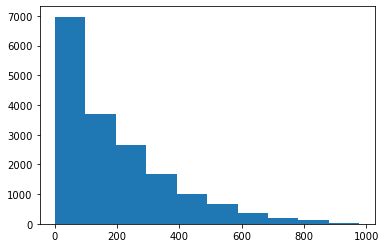

In [5]:
# distribution of total rentals:
plt.hist(bike_rentals['cnt'])
plt.show()

This is a right-skewed distribution, where most of the values cluster at the start of the range (i.e. approx. between 0 and 300 bikes rented in an hour of a day). Let's confirm this by computing the descriptive statistics.

In [6]:
bike_rentals['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

Mostly, the number of bikes rented at any given hour in a day don't exceed 281.

## Correlating columns with the `cnt` column

In [7]:
bike_rentals_corrmtx = bike_rentals.corr()

In [8]:
features_targetcol_correlation = bike_rentals_corrmtx['cnt']
features_targetcol_correlation

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

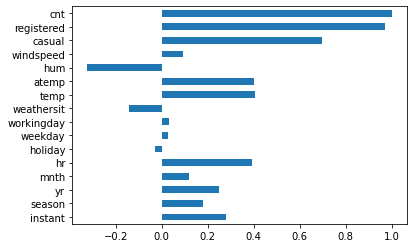

In [9]:
features_targetcol_correlation.plot.barh()
plt.show()

In [10]:
positively_correlated = features_targetcol_correlation[features_targetcol_correlation > 0].sort_values()
positively_correlated

weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

Observations :-
- `temp` and `atemp` features are moderately positively correlated to the number of bikes rented in an hour. This makes sense, as higher temperatures that are reasonable for outdoor activities makes the probability of people stepping out of their homes more likely.
- `hr` feature is also moderately positive, as increasing the hours usually coincides with business hour and leisure travelling, although further inspection might be needed.
- `yr` is weakly correlated.
- `season` feature shows positive correlation, as the transition from winter to spring to summer to fall seasons is marked by increased activity, which puts demand for transportation. This explains why number of bike rentals increase as seasons change to favorable ones.
- `mnth` feature is weakly correlated to hourly bike rentals. Though not strong, it's still important, as demand for bikes for tranportation increases as human activity generally grows as months pass by in the year.
- `windspeed` is surprisingly a positively correlated feature. A possible explanation could be that more speed, means faster travel. Nevertheless, the presence of strong winds might deter people from using bikes to avoid accidents, which counters this notion. As a result, the correlation strength is weak.
- `workingday` and `weekday` show an insignificant positive correlation.
- `instant` is an identifier for each record. Though it shows a decent enough correlation, it should not be considered as it is of no relevance when it comes to predicting models.
- `casual` and `registered` columns show a strong positive correlation with the `cnt` column, simply because they constitute the total number of bikes rented by hour. Hence, these too are not helpful when it comes to model predictions.
- `cnt` is the target attribute and any feature's correlation with itself is 1.

In [11]:
unrelated_pc_features = ['instant','casual','registered','cnt']
potential_positively_correlated_features = [col for col in positively_correlated.index if col not in unrelated_pc_features]
potential_positively_correlated_features

['weekday',
 'workingday',
 'windspeed',
 'mnth',
 'season',
 'yr',
 'hr',
 'atemp',
 'temp']

In [12]:
negatively_correlated = features_targetcol_correlation[features_targetcol_correlation < 0].sort_values(ascending=False)
negatively_correlated

holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

Observations :-
- `hum` is expectedly showing a moderately negative relationship with the number of bikes rented, as more humidity means increased chances of rain, and more discomfort associated with humid weather. Hence, people would be hesitent to rent out a bike for travelling.
- As `weathersit` increases in number (weather worsens, from the data dictionary provided above), it's obvious that the total number of hourly bike rentals would reduce.
- A weakly negative correlated feature, `holiday`, shows such a relationship likely due to lesser movement of people during holidays. While this seemingly contradicts the belief that travel associated with leisure is at it's peak during holidays, a possible explanation could be that people use other modes of transportation for visiting spots that are often located quite some distance away from where they live.

In [13]:
potential_negatively_correlated_features = list(negatively_correlated.index)
potential_negatively_correlated_features

['holiday', 'weathersit', 'hum']

# Calculating Features

It can often be helpful to calculate features before applying machine learning models as they enhance the accuracy of models by introducing new information or distilling existing information.

The `hr` column contains the hours during which bikes are rented, from 0 to 23. A machine treats each hour differently, without understanding that certain hours are related. 

We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This bundles similar times together, enabling the model to make better decisions.

Let's bundle hours according to the following logic:-
- 1: for hours from 6 to 12(exclusive) [morning]
- 2: for hours from 12 to 18(exclusive) [afternoon]
- 3: for hours from 18 to 0(exclusive) [evening]
- 4: for hours from 0 to 6(exclusive) [night]

In [14]:
def assign_label(hour_number):
    if (hour_number >=0) and (hour_number < 6):
        return 4
    elif (hour_number >= 6) and (hour_number < 12):
        return 1
    elif (hour_number >= 12) and (hour_number < 18):
        return 2
    else:
        return 3

In [15]:
# creating a new column that bundles the hours of a day:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals['time_label']

0        4
1        4
2        4
3        4
4        4
        ..
17374    3
17375    3
17376    3
17377    3
17378    3
Name: time_label, Length: 17379, dtype: int64

In [16]:
bike_rentals['time_label'].corr(bike_rentals['cnt'])

-0.3783183000693088

`time_label` as expected, captures the data better and shows a moderate negative correlationship with the target attribute. This can be attributed to the fact that morning is the peak time for work-related travel and workout. This wanes over the afternoon, as people work in office, and then abates in the evening, as bike might not be a safe mode of transport to return back to home in the evening. Finally, the lowest point is reached in the night, when people sleep.

In [17]:
potential_negatively_correlated_features.append('time_label')
potential_negatively_correlated_features

['holiday', 'weathersit', 'hum', 'time_label']

In [18]:
potential_positively_correlated_features.remove('hr')
potential_positively_correlated_features

['weekday', 'workingday', 'windspeed', 'mnth', 'season', 'yr', 'atemp', 'temp']

## Determining features that meaningfully contribute towards predicting the target attribute

From the looks of it, among the weak positively correlated features, `weekday` and `workingday` are not really showing glimpses of having a strong correlationship with the target attribute. Let's remove these.

In [19]:
potential_positively_correlated_features = [feature for feature in potential_positively_correlated_features if feature not in ['weekday','workingday']]
potential_positively_correlated_features

['windspeed', 'mnth', 'season', 'yr', 'atemp', 'temp']

The weak negatively correlated feature, `holiday` doesn't seem to fit into the scheme of things, i.e our final goal to determine hourly bike rentals. Let's eliminate it.

In [20]:
potential_negatively_correlated_features.remove('holiday')
potential_negatively_correlated_features

['weathersit', 'hum', 'time_label']

In [21]:
# checking correlation strength of features in consideration at this point
potential_features = [*potential_positively_correlated_features,*potential_negatively_correlated_features]

potential_features_corr_strength = bike_rentals.corr().loc[potential_features,'cnt'].abs().sort_values()
potential_features_corr_strength

windspeed     0.093234
mnth          0.120638
weathersit    0.142426
season        0.178056
yr            0.250495
hum           0.322911
time_label    0.378318
atemp         0.400929
temp          0.404772
Name: cnt, dtype: float64

This is a good base to begin with. Let's check for potential collinearity between features.

## Checking for collinearity between features

In [22]:
potential_features_corr_mtx = bike_rentals[potential_features].corr()
potential_features_corr_mtx

,windspeed,mnth,season,yr,atemp,temp,weathersit,hum,time_label
windspeed,1.000000,-0.135386,-0.149773,-0.008740,-0.062336,-0.023125,0.026226,-0.290105,-0.109462
mnth,-0.135386,1.000000,0.830386,-0.010473,0.208096,0.201691,0.005400,0.164411,0.005786
season,-0.149773,0.830386,1.000000,-0.010742,0.319380,0.312025,-0.014524,0.150625,0.006617
yr,-0.008740,-0.010473,-0.010742,1.000000,0.039222,0.040913,-0.019157,-0.083546,0.004755
atemp,-0.062336,0.208096,0.319380,0.039222,1.000000,0.987672,-0.105563,-0.051918,-0.057494
temp,-0.023125,0.201691,0.312025,0.040913,0.987672,1.000000,-0.102640,-0.069881,-0.061551
weathersit,0.026226,0.005400,-0.014524,-0.019157,-0.105563,-0.102640,1.000000,0.418130,-0.035784
hum,-0.290105,0.164411,0.150625,-0.083546,-0.051918,-0.069881,0.418130,1.000000,0.144593
time_label,-0.109462,0.005786,0.006617,0.004755,-0.057494,-0.061551,-0.035784,0.144593,1.000000


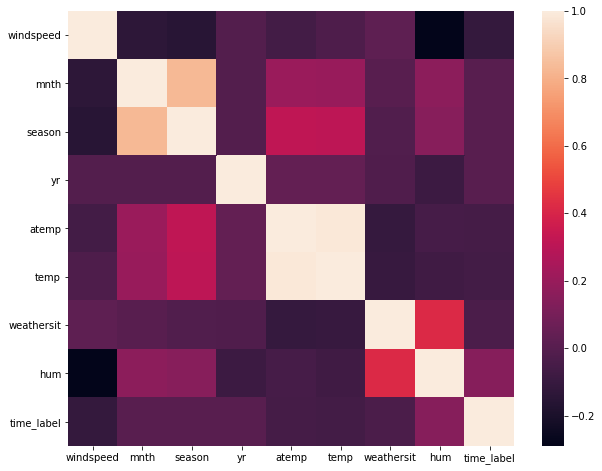

In [23]:
# plotting a correlation matrix heatmap
plt.figure(figsize=(10,8))
sns.heatmap(potential_features_corr_mtx)
plt.show()

Among the feature pairs that are highly correlated, those that might stand a risk of data duplication include :
- `atemp` and `temp`
- `mnth` and `season`
- `hum` and `weathersit`

From the data documentation and feature correlation strength w.r.t to target attribute,
- `atemp` seems to be a better choice than `temp`, as people often decide to rent a bike based on how their body percieves the temperature outside, rather than the temperature measured.
- `season` captures the information better than `mnth`, and the former is more strongly correlated with the target attribute relative to the latter.
- though `hum` and `weathersit` might sound similar, they are not exactly capturing the same information and same humidity values might mean different weather situations in different contexts. In addition, the relationship between these fetures is not so high, to make a clear decision of whether these features are collinear.

Let's reaffirm our findings, by actually cross-checking the correlation coefficient.

In [24]:
potential_features_corr_mtx.loc['atemp','temp']

0.9876721390396368

In [25]:
potential_features_corr_mtx.loc['mnth','season']

0.8303858922039996

In [26]:
potential_features_corr_mtx.loc['hum','weathersit']

0.41813032875177486

So, let's remove `temp` and `mnth` features.

In [27]:
potential_features = [feature for feature in potential_features if feature not in ['temp','mnth']]
potential_features

['windspeed', 'season', 'yr', 'atemp', 'weathersit', 'hum', 'time_label']

## Removing features with low variance

In [28]:
potential_features_data = bike_rentals[potential_features].copy()

normalized_feature_data = (potential_features_data - potential_features_data.min())/(potential_features_data.max() - potential_features_data.min())
normalized_feature_data

,windspeed,season,yr,atemp,weathersit,hum,time_label
0,0.000000,0.0,0.0,0.2879,0.000000,0.81,1.000000
1,0.000000,0.0,0.0,0.2727,0.000000,0.80,1.000000
2,0.000000,0.0,0.0,0.2727,0.000000,0.80,1.000000
3,0.000000,0.0,0.0,0.2879,0.000000,0.75,1.000000
4,0.000000,0.0,0.0,0.2879,0.000000,0.75,1.000000
...,...,...,...,...,...,...,...
17374,0.193018,0.0,1.0,0.2576,0.333333,0.60,0.666667
17375,0.193018,0.0,1.0,0.2576,0.333333,0.60,0.666667
17376,0.193018,0.0,1.0,0.2576,0.000000,0.60,0.666667
17377,0.157870,0.0,1.0,0.2727,0.000000,0.56,0.666667


In [29]:
normalized_feature_data.var().sort_values()

windspeed     0.020682
atemp         0.029532
hum           0.037222
weathersit    0.045420
season        0.136141
time_label    0.138207
yr            0.250008
dtype: float64

None of the features have really low variance to remove them. So, we will keep these features for training and predictions.

In [30]:
features = potential_features
features

['windspeed', 'season', 'yr', 'atemp', 'weathersit', 'hum', 'time_label']

In [31]:
target = 'cnt'

# Splitting the Data Into Train and Test Sets

The mean squared error(MSE), metric makes the most sense to evaluate our error while predicting. MSE works on continuous numeric data, which fits our data quite well.

In [32]:
# training set:
train = bike_rentals.sample(frac=0.8)

# testing set:
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

# Applying Linear Regression

Linear regression works fairly well on this data as:
1. Many of the columns are highly correlated with `cnt`.
2. The predictors(columns) are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other.
3. It's fairly resistant to overfitting because it's straightforward.

However, it also can be prone to underfitting the data, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

In [33]:
# training:
lin_reg_mdl = LinearRegression()
lin_reg_mdl = lin_reg_mdl.fit(train[features],train[target])

# predictions:
linear_regression_predictions = lin_reg_mdl.predict(test[features])

# prediction quality:
linear_regression_mse = mean_squared_error(test[target],linear_regression_predictions)
linear_regression_mse

18939.363295741485

The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

# Applying Decision Trees

Decision trees tend to predict outcomes much more reliably than linear regression models, because a decision tree is a fairly complex model.

However,
- it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. 
- Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [34]:
# training:
des_tree_reg_mdl = DecisionTreeRegressor(min_samples_leaf=5)
des_tree_reg_mdl = des_tree_reg_mdl.fit(train[features],train[target])

# predictions:
decision_tree_predictions = des_tree_reg_mdl.predict(test[features])

# prediction quality:
decision_tree_mse = mean_squared_error(test[target],decision_tree_predictions)
decision_tree_mse

17269.907942371967

By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

# Applying Random Forests

The random forest algorithm improves on the decision tree algorithm and tend to be much more accurate than simple models like linear regression. 

Due to the way random forests are constructed, they tend to overfit much less than decision trees. 
- Random forests are prone to overfitting, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [35]:
# training:
rand_forst_reg_mdl = RandomForestRegressor(min_samples_leaf=5)
rand_forst_reg_mdl = rand_forst_reg_mdl.fit(train[features],train[target])

# predictions:
random_forest_predictions = rand_forst_reg_mdl.predict(test[features])

# prediction quality:
random_forest_mse = mean_squared_error(test[target],random_forest_predictions)
random_forest_mse

13603.737385013581

By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.